In [1]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

In [2]:
%pwd 

'/Users/carliarbon'

In [3]:
#import df and see shape 

dog_df=pd.read_csv(f'/Users/carliarbon/Downloads/dogs2.csv')

print(dog_df.shape)
dog_df.head(5)

(172, 46)


,dogBreed,category,datadogScore,popularityinUsPureBreeds,popularityInUs,lifetimeCost,lifetimeCostRank,intelligenceRanking,IntelligencePercentage,longevity,...,LifetimeCostUSD,LifetimeCostPercentage,avgPurchasePrice,priceBracket,lowestPrice,highestPrice,foodCostPerWk,foodPerYr,foodPerLifetime,Other regular costs total per lifetime $
0,Border Collie,herding,3.64,45,39.0,$20143.00,48%,1,100%,12.52,...,"17,404",48%,623,budget,175,1050,5.34,278.0,3486,13095
1,Border Terrier,terrier,3.61,80,61.0,$22638.00,14%,30,70%,14.00,...,"19,575",14%,833,mid-price,250,1200,5.34,278.0,3898,14643
2,Brittany,sporting,3.54,30,30.0,$22589.00,16%,19,80%,12.92,...,"19,503",16%,618,budget,300,1200,7.67,400.0,5171,13514
3,Cairn Terrier,terrier,3.53,59,48.0,$21992.00,22%,35,61%,13.84,...,"18,965",23%,435,budget,300,600,5.34,278.0,3854,14476
4,Welsh Springer Spaniel,sporting,3.34,130,81.0,$20224.00,47%,31,69%,12.49,...,"17,492",46%,750,mid-price,750,750,5.34,278.0,3478,13064


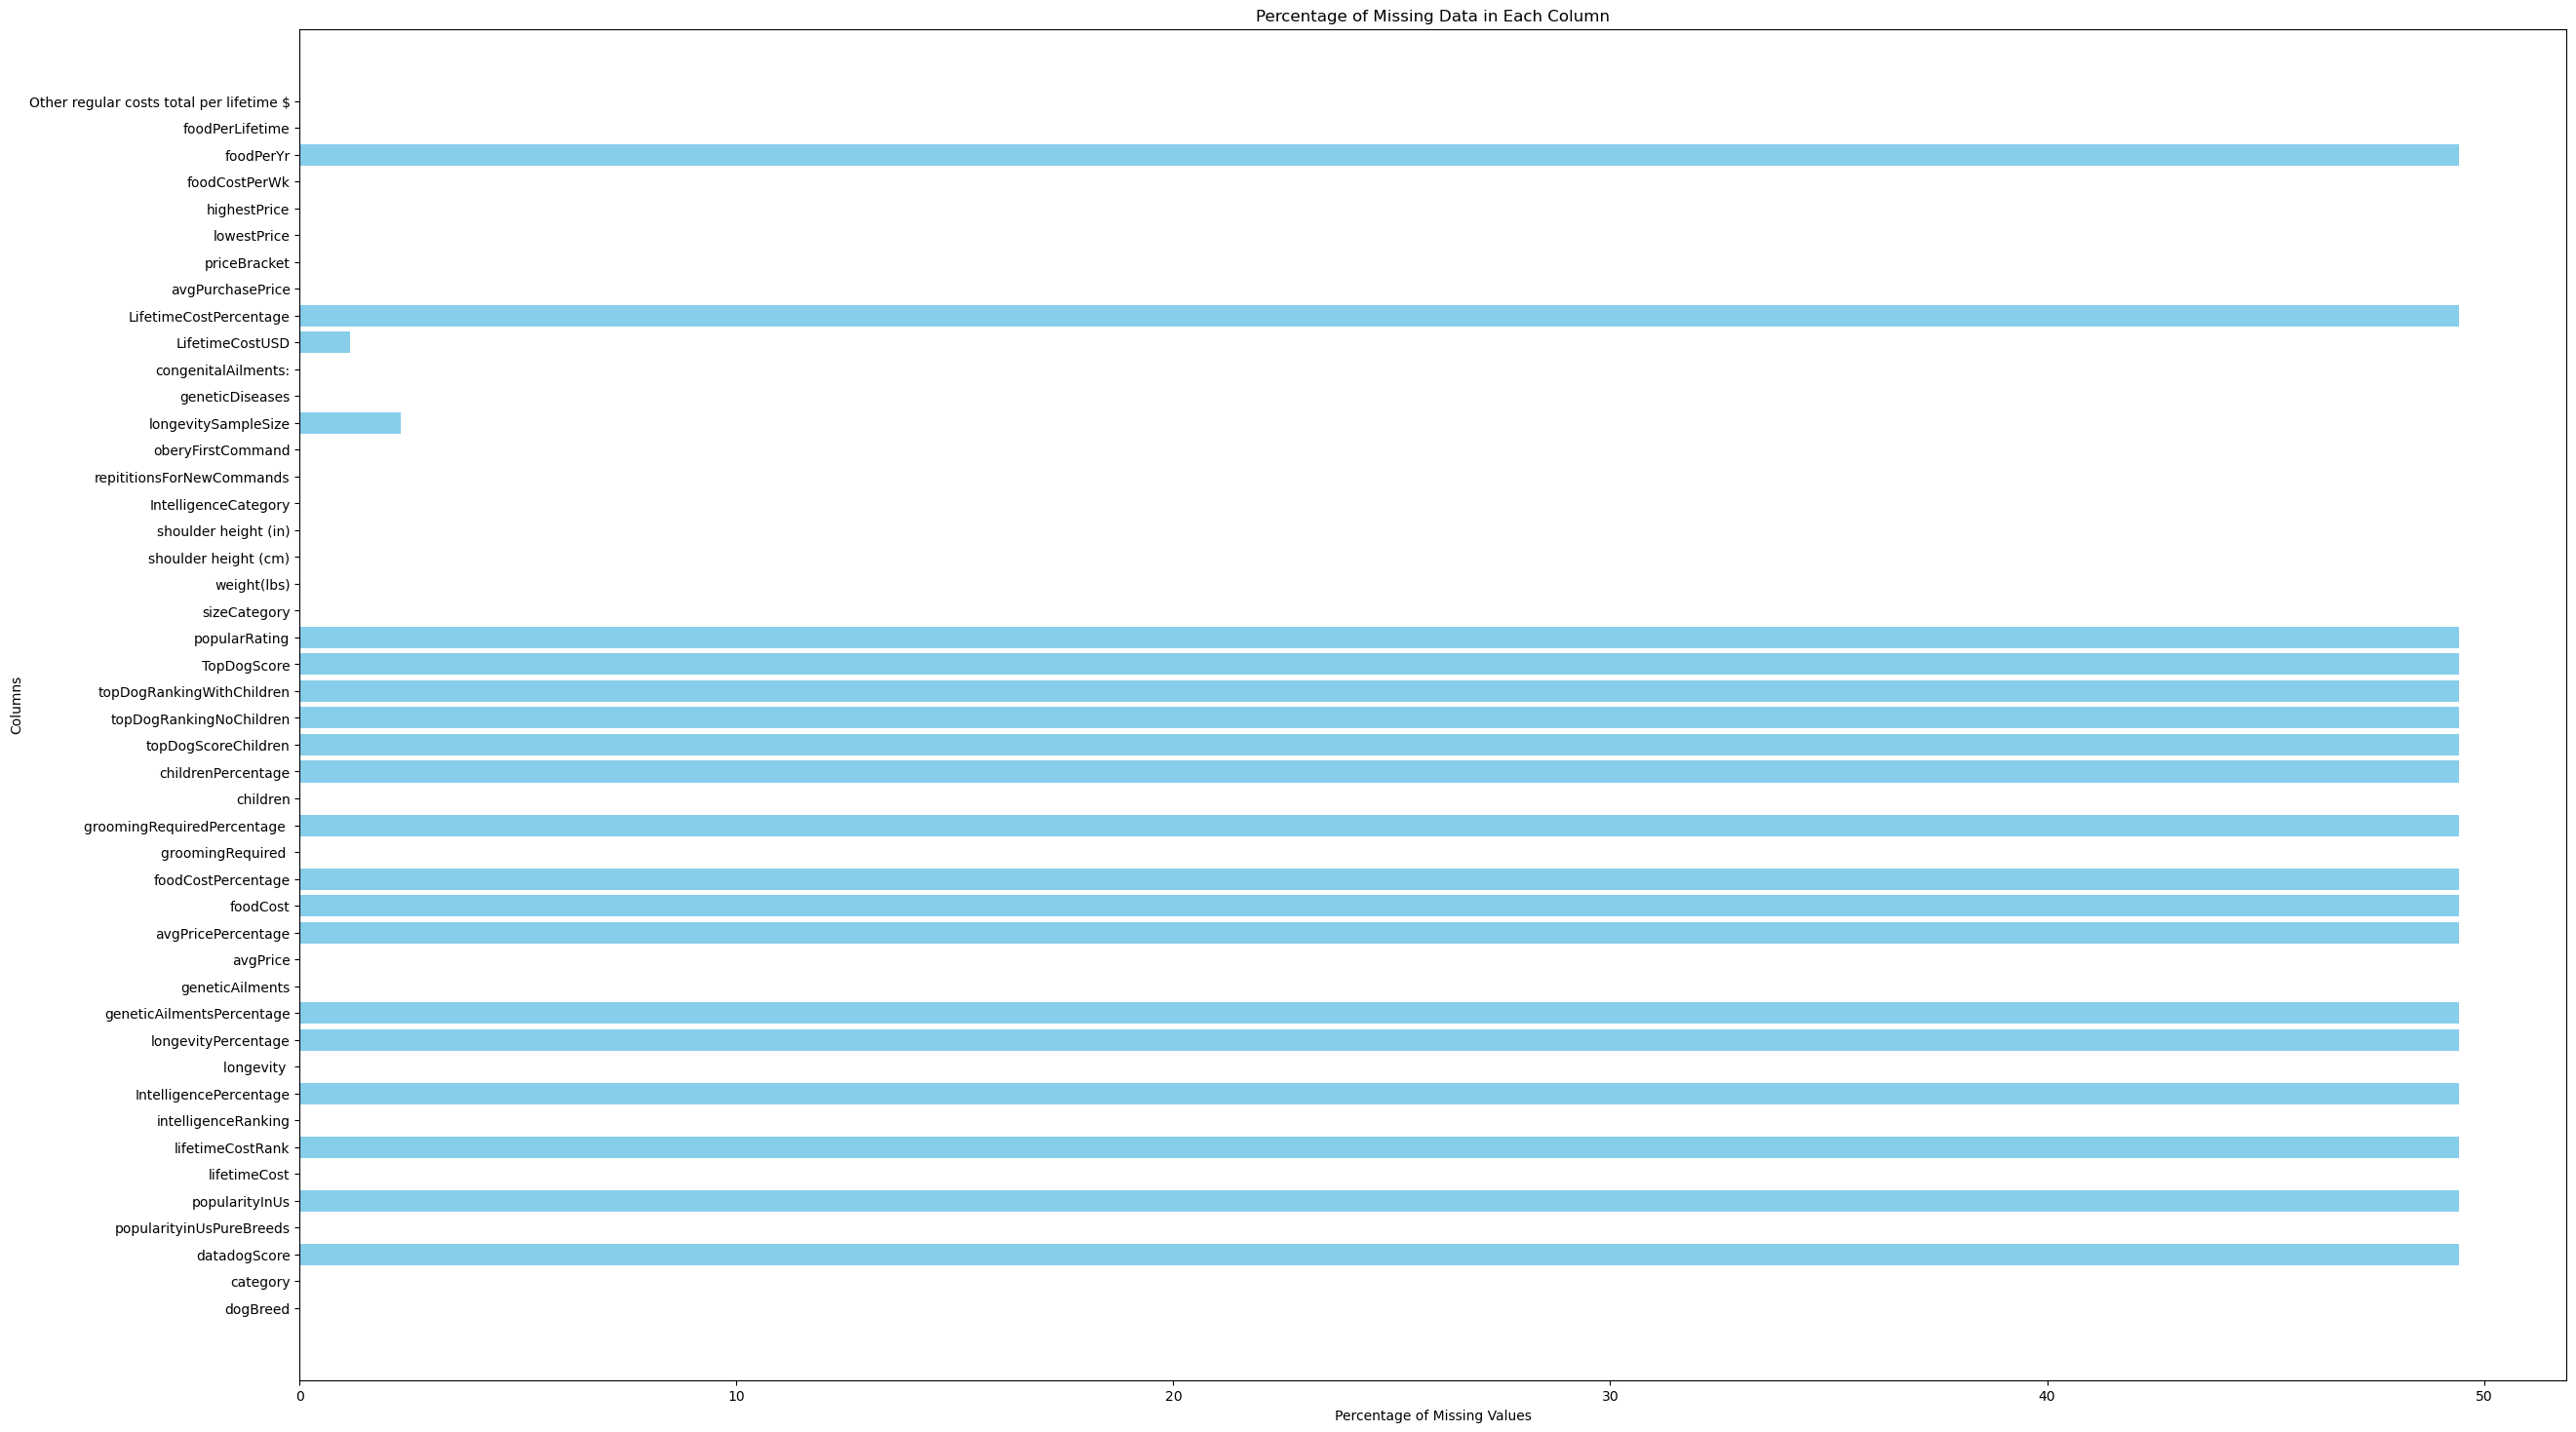

In [4]:
#calculate and display number of missing values in each column
# I wanted to see which columns had the least missing data in order to determine which factors to use 
missing_counts = dog_df.isnull().sum()

# Calculate percentage of missing values in each column
missing_percentages = (missing_counts / len(dog_df)) * 100

# Create a bar plot to visualize the missing data 
plt.figure(figsize=(30, 18))
plt.barh(missing_percentages.index, missing_percentages.values, color='skyblue')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns')
plt.title('Percentage of Missing Data in Each Column')
plt.show()

In [5]:
# I pre Processed the data in the following two cells. first I converted the average price into a numeric value 
#as well as deleted any NaN value. Then I converted the data in the 'children' column into string values 
def preprocess_data(df):
    df['avgPrice'] = pd.to_numeric(df['avgPrice'].str.replace('$', '', regex=False), errors='coerce')
    df = df.dropna(subset=['avgPrice'])
    df['children'] = df['children'].astype(str)
    return df

dog_df = preprocess_data(dog_df)

/var/folders/bh/djmgbj6n173cr1fx_0yw27380000gn/T/ipykernel_5348/3393365247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['children'] = df['children'].astype(str)


In [6]:
# I converted the values in the Intelliegence, category, priceBracket, and sizeCategory into numerical values for modeling
# I used Sci Kit Learn label encoders to do this 

label_encoders = {}
for column in ['IntelligenceCategory', 'category', 'priceBracket', 'sizeCategory']:
    le = LabelEncoder()
    dog_df[column] = le.fit_transform(dog_df[column])
    label_encoders[column] = le

In [7]:
# Fit Nearest Neighbors model. Create Nearest Neighbors model with 5 neighbors and ball_tree algorithm
#and then fit it to the model 
X = dog_df[['IntelligenceCategory','category', 'children', 'priceBracket','sizeCategory']]
if not X.empty:
    nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
    nn_model.fit(X)

##### Find Similar Breeds Function

In [8]:
#This code creates a method to find similar dog breeds using the Nearest neighbors method. 
#The function uses the Intelligence Category, dog breed category (category), suitability for children (children), price bracket, and size category to determinine the similarities
#It will select breeds that are 80% similar and show at  up to 5 breeds 

def find_similar_breeds(selected_breed):
    selected_breed_data = dog_df.loc[dog_df['dogBreed'] == selected_breed, [ 'IntelligenceCategory','category', 'children', 'priceBracket', 'sizeCategory']]
        
    similar_breeds = []
    if not selected_breed_data.empty:
        _, indices = nn_model.kneighbors(selected_breed_data)
        similar_breeds_indices = indices[0]
        for index in similar_breeds_indices:
            similar_breed_data = dog_df.iloc[index]
            if similar_breed_data['dogBreed'] != selected_breed:  # Exclude the selected breed
                similarity_score = sum(selected_breed_data.values.flatten() == similar_breed_data[['IntelligenceCategory', 'category', 'children', 'priceBracket', 'sizeCategory']].values.flatten()) / len(selected_breed_data.columns)
                if similarity_score >= 0.8 or len(similar_breeds) < 5:  
                    similar_breeds.append(similar_breed_data)
                    if len(similar_breeds) >= 5:
                        break
        if not similar_breeds:
            return "No similar breeds." 
    else:
        return "No similar breeds." 
    return pd.DataFrame(similar_breeds)


In [9]:
# Function to handle breed selection and display similar breeds
# User chooses the  the selected breed from the dropdown
# Display information about similar breeds in the text widget
def get_similar_breeds():
    selected_breed = breed_var.get()
    similar_breeds_df = find_similar_breeds(selected_breed)
    result_text.delete(1.0, tk.END)
    for index, row in similar_breeds_df.iterrows():
        breed_name = row['dogBreed']
        price_bracket = label_encoders['priceBracket'].inverse_transform([row['priceBracket']])[0] #converts from numerical values to the categorical values 
        intelligence_category = label_encoders['IntelligenceCategory'].inverse_transform([row['IntelligenceCategory']])[0]
        breed_category = label_encoders['category'].inverse_transform([row['category']])[0]
        size_category = label_encoders['sizeCategory'].inverse_transform([row['sizeCategory']])[0]
        
        result_text.insert(tk.END, f"Dog Breed: {breed_name}\n")
        result_text.insert(tk.END, f"Price Bracket: {price_bracket}\n")
        result_text.insert(tk.END, f"Average Purchase Price $:{row['avgPurchasePrice']}\n")
        result_text.insert(tk.END, f"Size:{size_category}\n")
        result_text.insert(tk.END, f"Average Weight (lbs): {row['weight(lbs)']}\n")
        result_text.insert(tk.END, f"Breed Category:{breed_category}\n")
        result_text.insert(tk.END, f"Children 1 =high suitability, 2=medium suitability, 3=low suitability:{row['children']}\n")
        result_text.insert(tk.END, f"Intelligence Category: {intelligence_category}\n\n")
        result_text.insert(tk.END, f"Genetic Ailments: {row['geneticDiseases']}\n\n")



In [10]:
# Create Tkinter window
window = tk.Tk()
window.title("Dog Breed Recommender")

# Create dropdown values with spaces between words and sorted alphabetically
dropdown_values = sorted([breed.replace(" ", " ") for breed in dog_df['dogBreed'].unique()])

# Create label and dropdown for breed selection
breed_label = tk.Label(window, text="Select Dog Breed:")
breed_label.grid(row=0, column=0, padx=5, pady=5, sticky="w")
breed_var = tk.StringVar(window)
breed_dropdown = ttk.Combobox(window, textvariable=breed_var, values=dropdown_values)
breed_dropdown.grid(row=0, column=1, padx=5, pady=5)

# Create button to find similar breeds
find_button = tk.Button(window, text="Find Similar Breeds", command=get_similar_breeds)
find_button.grid(row=1, column=0, columnspan=2, padx=5, pady=5)

# Create a text widget to display similar breeds
result_text = tk.Text(window, height=10, width=50)
result_text.grid(row=2, column=0, columnspan=2, padx=5, pady=5)

window.mainloop()

In [11]:
from sklearn.metrics import f1_score

def test_f1_score():
    # Define test data (ground truth) and predicted data
    test_data = {
        'Golden Retriever': ['Labrador Retriever', 'Vizsla', 'Wirehaired Pointing Griffon', 'English Cocker Spaniel'],
        'Akita': ['Alaskan Malamute', 'Doberman Pinscher', 'Rottweiler', 'Giant Schnauzer'],
        'Boston Terrier': ['West Highland White Terrier', 'Bichon Frise', 'Norwegian Elkhound','Tibetan Spaniel'],
        'German Shepherd': ['Belgian Malinois', 'American Foxhound', 'Rhodesian Ridgeback', 'Belgian Tervuren'],
        'Australian Shepherd': ['Australian Cattle Dog', 'Border Collie',  'Black and Tan Coonhound', 'Shetland Sheepdog'],   
        'Boxer': ['Great Dane', 'Alaskan Malamute', 'Samoyed', 'Newfoundland'],
        'Pug': ['Chinese Crested', 'Japanese Chin', 'Shih Tzu', 'Skye Terrier'],
        'Maltese': ['Chihuahua', 'Pomeranian', 'Skye Terrier', 'Norfolk Terrier'],
        'Bernese Mountain Dog': ['Standard Schnauzer', 'Bullmastiff', 'Saint Bernard', 'Rottweiler'],
        'Yorkshire Terrier': ['Manchester Terrier', 'Norwich Terrier', 'English Toy Spaniel', 'Kerry Blue Terrier']
    }

    predicted_data = {
        'Golden Retriever': ['Labrador Retriever', 'Irish Setter', 'Chesapeake Bay Retriever', 'Flat-Coated Retriever'],
        'Akita': ['Shiba Inu', 'Siberian Husky', 'Alaskan Malamute', 'Chow Chow'],
        'Boston Terrier': ['French Bulldog', 'Pug', 'Cavalier King Charles Spaniel', 'English Bulldog'],
        'German Shepherd': ['Belgian Malinois', 'Dutch Shepherd', 'Belgian Tervuren', 'Doberman Pincher'],
        'Australian Shepherd':  ['Border Collie', 'Shetland Sheepdog', 'Border Terrier', 'Australian Cattle Dog'],  
        'Boxer': ['Bullmastiff', 'American Staffordshire Terrier', 'American Bulldog', 'Doberman Pinscher'],
        'Pug': ['French Bulldog', 'Boston Terrier', 'Cavalier King Charles Spaniel', 'English Bulldog'],
        'Maltese': ['Bichon Frise', 'Havanese', 'Coton de Tulear', 'Shih Tzu'],
        'Bernese Mountain Dog': ['Greater Swiss Mountain Dog', 'Saint Bernard', 'Newfoundland', 'Great Pyrenees'],
        'Yorkshire Terrier': ['Silky Terrier', 'Maltese', 'Shih Tzu', 'Cavalier King Charles Spaniel']
    }

    # Ensure consistency between test data and predicted data
    for breed in test_data:
        if breed not in predicted_data:
            predicted_data[breed] = [] 

    # Flatten the dictionary values
    y_true = [breed for sublist in test_data.values() for breed in sublist]
    y_pred = [breed for sublist in predicted_data.values() for breed in sublist]

    # Evaluate the model
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return f1

# Test the F1 score
f1_score = test_f1_score()
print("F1-score:", f1_score)


F1-score: 0.05


In [12]:
#### Dog Finder Function 

# This application allowsusers to filter dogs based on aspects of their chosing 

In [21]:
# Define dictionaries to map encoded values to labels since the categorical data was converted to numerical data 
intelligence_labels = {
    0: 'Lowest',
    1: 'Fair',
    2: 'Average',
    3: 'Above average',
    4: 'Brightest',
    5: 'Excellent',
    6: 'No Data' 
}

size_labels = {
    0: 'large',
    1: 'medium',
    2: 'small',
   
}

price_labels = {
    0: 'budget',
    1:'mid-price',
    2:'high-end'
}


In [22]:
#This function filters the dogs based on the input by the user 
#The user can select data for the chilcren, intelligenec, price and dog breed categories 

def filter_dogs():
    global dog_df  
    children_value = children_var.get()
    intelligence_value = intelligence_var.get()
    price_value = price_var.get()
    size_value = size_var.get()

    print("Selected values:")
    print("Children:", children_value)
    print("Intelligence:", intelligence_value)
    print("Price:", price_value)
    print("Size:", size_value)

    # Convert label values back to encoded values
    children_value_encoded = next((k for k, v in intelligence_labels.items() if v == children_value), None)
    intelligence_value_encoded = next((k for k, v in intelligence_labels.items() if v == intelligence_value), None)
    price_value_encoded = next((k for k, v in price_labels.items() if v == price_value), None)
    size_value_encoded = next((k for k, v in size_labels.items() if v == size_value), None)

    # Filter based on selected options or include all if "Any" is selected
    filtered_dogs = dog_df[
        ((dog_df['children'] == children_value_encoded) if children_value != "Any" else True) &
        ((dog_df['IntelligenceCategory'] == intelligence_value_encoded) if intelligence_value != "Any" else True) &
        ((dog_df['priceBracket'] == price_value_encoded) if price_value != "Any" else True) &
        ((dog_df['sizeCategory'] == size_value_encoded) if size_value != "Any" else True)
    ]

    print("Filtered DataFrame shape:", filtered_dogs.shape)
    
    if filtered_dogs.empty:
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, "No dogs found")
    else:
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, "Matching Dogs:\n\n")
        for index, row in filtered_dogs.iterrows():
            result_text.insert(tk.END, f"Dog Breed: {row['dogBreed']}\n")
            result_text.insert(tk.END, f"Size: {size_labels[row['sizeCategory']]}\n")
            result_text.insert(tk.END, f"Breed Category: {category_labels[row['category']]}\n")
            result_text.insert(tk.END, f"Average Price:$ {row['avgPrice']}\n")
            result_text.insert(tk.END, f"Intelligence Category: {intelligence_labels[row['IntelligenceCategory']]}\n")
            result_text.insert(tk.END, f"Good with Children: {row['children']}\n")
            result_text.insert(tk.END, f"Genetic Ailments: {row['geneticDiseases']}\n\n")


In [24]:
# Create Tkinter window
window = tk.Tk()
window.title("Dog Finder")

# Create labels for user input 
category_label = tk.Label(window, text="Size:")
category_label.grid(row=3, column=0, padx=5, pady=5, sticky="w")

intelligence_label = tk.Label(window, text="Intelligence Category:")
intelligence_label.grid(row=1, column=0, padx=5, pady=5, sticky="w")

children_label = tk.Label(window, text="Children (1 - highly suitable. 2 - medium suitability. 3 - low suitability):")
children_label.grid(row=0, column=0, padx=5, pady=5, sticky="w")

price_label = tk.Label(window, text="Price Bracket:")
price_label.grid(row=2, column=0, padx=5, pady=5, sticky="w")


# Create dropdowns with labels
children_var = tk.StringVar(window)
children_dropdown_values = ["Any"] + sorted(dog_df['children'].unique())  # Use labels instead of encoded values as well as incorporate the 'Any' selection 
children_dropdown = ttk.Combobox(window, textvariable=children_var, values=children_dropdown_values)
children_dropdown.grid(row=0, column=1, padx=5, pady=5)

intelligence_var = tk.StringVar(window)
intelligence_dropdown_values = ["Any"] + sorted(intelligence_labels.values()) 
intelligence_dropdown = ttk.Combobox(window, textvariable=intelligence_var, values=intelligence_dropdown_values)
intelligence_dropdown.grid(row=1, column=1, padx=5, pady=5)

price_var = tk.StringVar(window)
price_dropdown_values = ["Any"] + sorted(price_labels.values()) 
price_dropdown = ttk.Combobox(window, textvariable=price_var, values=price_dropdown_values)
price_dropdown.grid(row=2, column=1, padx=5, pady=5)

size_var = tk.StringVar(window)
size_dropdown_values = ["Any"] + sorted(size_labels.values()) 
size_dropdown = ttk.Combobox(window, textvariable=size_var, values=size_dropdown_values)
size_dropdown.grid(row=3, column=1, padx=5, pady=5)


# Create a button to filter dogs
filter_button = tk.Button(window, text="Find Dogs ", command=filter_dogs)
filter_button.grid(row=4, column=0, columnspan=2, padx=5, pady=5)

# Create a text widget to display the result
result_text = tk.Text(window, height=10, width=50)
result_text.grid(row=5, column=0, columnspan=2, padx=5, pady=5)

window.mainloop()


Selected values:
Children: Any
Intelligence: Any
Price: Any
Size: small
Filtered DataFrame shape: (50, 46)
